# Разработка решения, которое поможет удержать активность постоянных клиентов.

Интернет магазин "В один клик" занимается продажей разных товаров. В результате отчета о посещении магазина, выяснилось, что число пользователей начало снижаться и это негативно влияет на продажи компании. Было принято решение разработать модель машинного обучения, которая сможет сделать персонализированные предложения для постоянных клиентов магазина и сможет удержать их на сайте.  

Сайт предоставил следующие данные для исследования и последующего обучения МО: данные о поведении покупателя на сайте; данные о выручке, которую сайт получает от покупателя; данные о времени, которое пользователь провел на сайте; данные о прибыли, которую магазин получает от каждого покупателя в течения 3 месяца.  

Этапы работы:
1. Загрузка и предобработка данных;
2. Исследовательский анализ данных;
3. Корреляционный анализ данных;
4. С помощью метода "пайп-лайн" проверим различные модели МО и их настройки, для выявления более подходящей для поставленной задачи;
5. Анализ важности признаков и сегментация покупателей;
6. Общий вывод;

## Загрузка данных

In [2]:
%pip install -U ipykernel --user
%pip install -q --upgrade scikit-learn --user
%pip install -q --upgrade seaborn --user
%pip install -q --upgrade matplotlib --user
%pip install -q --upgrade numba --user
%pip install -q --upgrade shap --user
%pip install phik -q --user
%pip install shap -q --user
%pip install --upgrade scipy --user
import numpy as np
import pandas as pd
import shap
import phik
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler
                                  )
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#загрузка таблиц с помощью билиотеки pandas
market_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')
#проверим содержание таблиц
print('Таблица с информацией о поведении пользователя на сайте')
display(market_data.head())
print('Таблица с информацией о выручке, которуя сайт получает от покупателей')
display(market_money.head())
print('Таблица с информацией о времени, проведенном пользователем на сайте')
display(market_time.head())
print('Таблица с информацией о прибыли полученной от покупателей')
money.head()

Таблица с информацией о поведении пользователя на сайте


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Таблица с информацией о выручке, которуя сайт получает от покупателей


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Таблица с информацией о времени, проведенном пользователем на сайте


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Таблица с информацией о прибыли полученной от покупателей


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Выведем общую информацию по таблицам

In [4]:
print('Таблица с информацией о поведении пользователя на сайте')
display(market_data.info())
print('Таблица с информацией о выручке, которуя сайт получает от покупателей')
display(market_money.info())
print('Таблица с информацией о времени, проведенном пользователем на сайте')
display(market_time.info())
print('Таблица с информацией о прибыли полученной от покупателей')
money.info()

Таблица с информацией о поведении пользователя на сайте
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   130

None

Таблица с информацией о выручке, которуя сайт получает от покупателей
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Таблица с информацией о времени, проведенном пользователем на сайте
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Таблица с информацией о прибыли полученной от покупателей
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [5]:
#приведем первые названия колонок в первой таблице к единому стилю написания
market_data.columns = ['id',
                       'Покупательская_активность',
                       'Тип_сервиса',
                       'Разрешить_сообщать',
                       'Маркет_актив_6_мес',
                       'Маркет_актив_тек_мес',
                       'Длительность',
                       'Акционные_покупки',
                       'Популярная_категория',
                       'Средний_просмотр_категорий_за_визит',
                       'Неоплаченные_продукты_штук_квартал',
                       'Ошибка_сервиса',
                       'Страниц_за_визит'
                      ]

При поверхностном осмотре таблиц несоответствий содержимого с описанием таблиц не видно. Только в первой таблице некоторые названия колонок не придерживались общего стиля написания, что было исправлено. В колонке "тип серивиса" категорию "стандартт" стоит грамматически исправить. Числовые значения в таблицах не нуждаются в дополнительной обработке.

## Предобработка данных

**Проверим наличие пропусков и неявных дубликатов в таблицах** 

In [6]:
#для проверки используем функцию
def completeness_check(ittor, table):
    print('Пропусков в таблице', table)
    print(ittor.isna().sum())
    value = ittor.duplicated().sum()
    print(f'Полных дубликатов в таблице {table} - {value}')

In [7]:
#проверим таблицу с информацией о поведении пользователей сайте
completeness_check(market_data, 'с поведением пользователей')

Пропусков в таблице с поведением пользователей
id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
Полных дубликатов в таблице с поведением пользователей - 0


In [8]:
#таблица с информацией о выручке
completeness_check(market_money, 'с выручкой сайта')

Пропусков в таблице с выручкой сайта
id         0
Период     0
Выручка    0
dtype: int64
Полных дубликатов в таблице с выручкой сайта - 0


In [9]:
#таблица с информацией о времени
completeness_check(market_time, 'с проведенным временем')

Пропусков в таблице с проведенным временем
id        0
Период    0
минут     0
dtype: int64
Полных дубликатов в таблице с проведенным временем - 0


In [10]:
#таблица с информацией о прибыли
completeness_check(money, 'с прибылью по каждому пользователю за 3 месяца')

Пропусков в таблице с прибылью по каждому пользователю за 3 месяца
id         0
Прибыль    0
dtype: int64
Полных дубликатов в таблице с прибылью по каждому пользователю за 3 месяца - 0


**Пропусков в таблицах не обнаружили, дубликатов тоже. Проверим теперь неявные дубликаты в колонках со строковыми значениями.**

In [11]:
market_data_type_object = market_data.select_dtypes('object').columns
def unique_check(data, ittor):
    for i in ittor:
        print(f'Cтолбец: - {i}')
        print(data[i].sort_values().unique())

In [12]:
unique_check(market_data, market_data_type_object)

Cтолбец: - Покупательская_активность
['Прежний уровень' 'Снизилась']
Cтолбец: - Тип_сервиса
['премиум' 'стандарт' 'стандартт']
Cтолбец: - Разрешить_сообщать
['да' 'нет']
Cтолбец: - Популярная_категория
['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']


В колонке "тип сервиса" есть две одинаковые категории с разных написанием, следует привести их к одному виду

In [13]:
market_data['Тип_сервиса'] = market_data['Тип_сервиса'].str.replace('стандартт', 'стандарт')
#проверим изменения
unique_check(market_data, market_data_type_object)

Cтолбец: - Покупательская_активность
['Прежний уровень' 'Снизилась']
Cтолбец: - Тип_сервиса
['премиум' 'стандарт']
Cтолбец: - Разрешить_сообщать
['да' 'нет']
Cтолбец: - Популярная_категория
['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']


In [14]:
unique_check(market_money, ['Период'])

Cтолбец: - Период
['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц']


Видим три разные категории в колонке. С написанием все в порядке.

In [15]:
unique_check(market_time, ['Период'])

Cтолбец: - Период
['предыдцщий_месяц' 'текущий_месяц']


Для этой таблицы так же исправляем грамматическую ошибку в названии категории

In [16]:
market_time['Период'] = market_time['Период'].str.replace('дцщий', 'дущий')
#проверим изменения
unique_check(market_money, ['Период'])

Cтолбец: - Период
['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц']


При проверке данных: пропусков и полных дубликатов не обнаружили. Исправили написание категорий в столбцах на однотипное, чтобы убрать неявные дубликаты. В последней таблице нет столбцов со строковым типом данных, поэтому она в проверке не нуждается.

## Исследовательский анализ данных

Рассмотрим распределение категориальных признаков в таблицах.

In [17]:
def bar_build(data, ittor):
    for i in ittor:
        print(f'Распределение в колонке - {i}')
        value_counts = data[i].value_counts()
        plt.figure(figsize=(8, 4))
        plt.bar(value_counts.index, value_counts.values)
        plt.title('Гистограмма распределения')
        plt.xticks(rotation=30, ha='right')
        plt.xlabel('Категория')
        plt.ylabel('Сумма значений каждой категории')
        plt.show()

Распределение категориальных значений в таблице с поведением покупателя на сайте
Распределение в колонке - Покупательская_активность


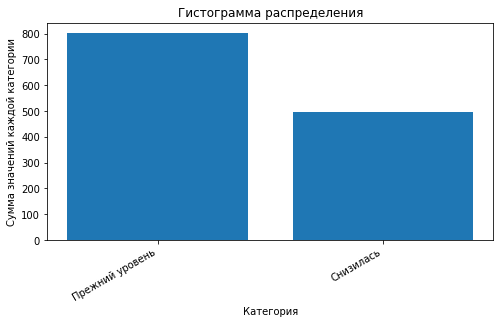

Распределение в колонке - Тип_сервиса


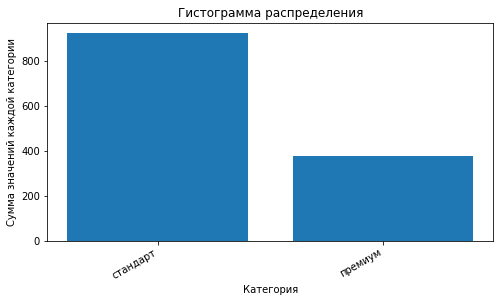

Распределение в колонке - Разрешить_сообщать


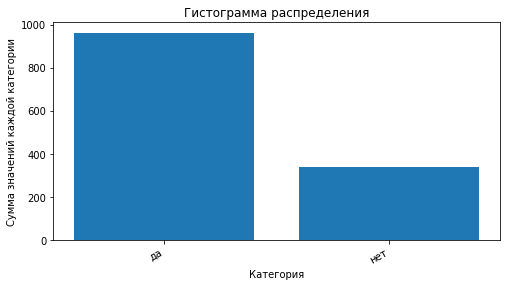

Распределение в колонке - Популярная_категория


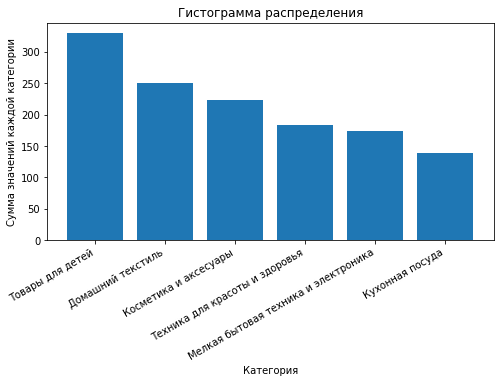

In [18]:
print('Распределение категориальных значений в таблице с поведением покупателя на сайте')
bar_build(market_data, market_data_type_object)

Судя по графикам видим, что:
* Пользовательская активность действительно начала снижаться;
* Пользователй со стандартным доступом к сайту больше чем, класса премиум;
* Большая часть пользователей разрешили присылать им дополнительные предложения по товару;
* ТОвары для детей пользуються самой большой популярностью, далее по убыванию идут: домашний текстиль, косметика и аксесуары, техника для красоты и здоровья, мелкая бытовая техника и электроника и кухонная посуда самая не популярная.

Распределение категориального значения в таблице с выручкой магазина
Распределение в колонке - Период


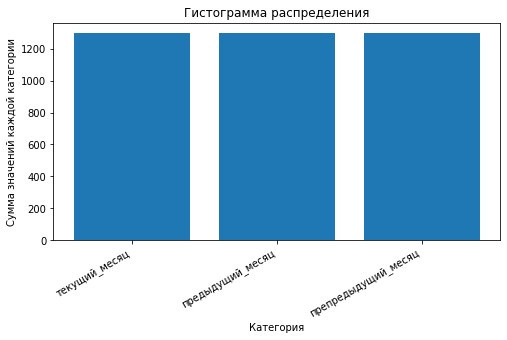

In [19]:
print('Распределение категориального значения в таблице с выручкой магазина')
#отберем тех, от кого выручка была не нулевая, так можно понять, что пользователь был активным
market_money_active = market_money.loc[market_money['Выручка'] > 0]
bar_build(market_money_active, ['Период'])

В прошлом месяце сайт получил получил выручки в два раза больше, чем в текущем, это так же можно объяснить снижением активностью.

Распределение категориального значения в таблице со временем, которое пользователь провел за период
Распределение в колонке - Период


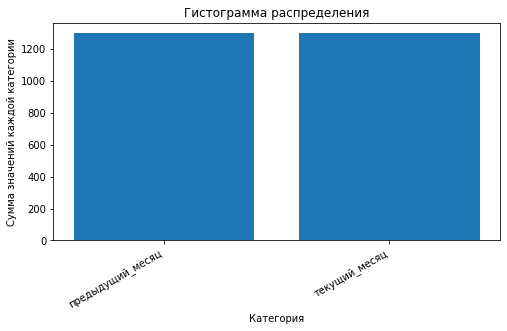

In [20]:
print('Распределение категориального значения в таблице со временем, которое пользователь провел за период')
bar_build(market_time, ['Период'])

В прошлом и текущем месяце, пользователи провели примерно одинаковое время на сайте, значит время не может быть причиной снижения пользовательской активности.

**Теперь проверим распределение числовых значений в таблицах.**

Колонка - "Маркет_актив_6_мес"


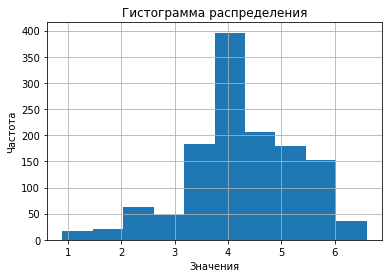

Колонка - "Акционные_покупки"


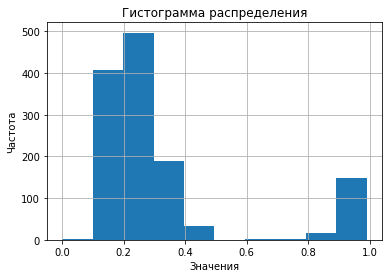

Колонка - "Длительность"


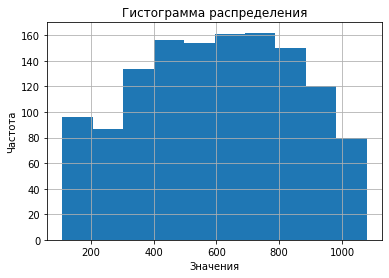

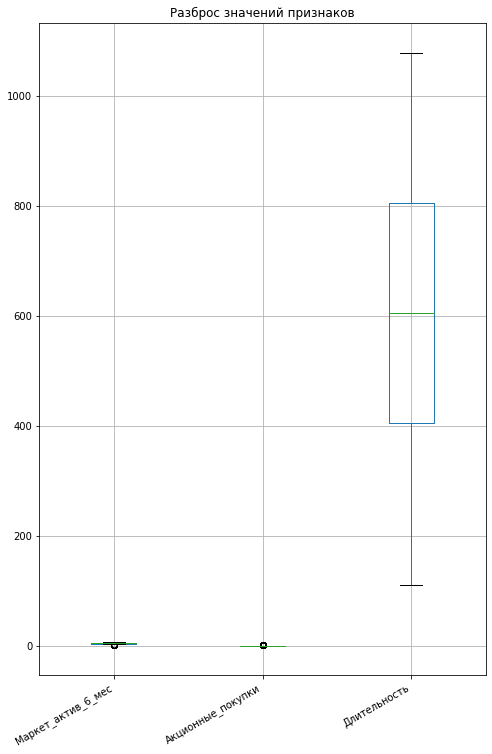

Колонка - "Маркет_актив_тек_мес"


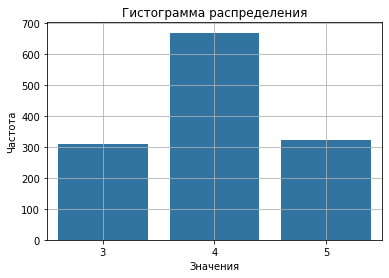

Колонка - "Средний_просмотр_категорий_за_визит"


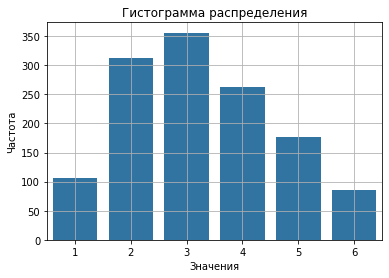

Колонка - "Неоплаченные_продукты_штук_квартал"


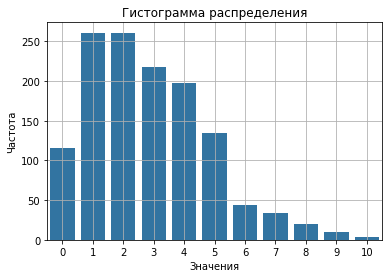

Колонка - "Ошибка_сервиса"


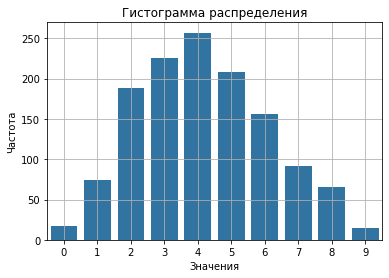

Колонка - "Страниц_за_визит"


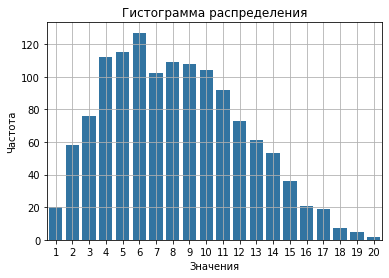

In [21]:
#выделим колонки с числовым типом данных
market_data_numeric = ['Маркет_актив_6_мес',
                       'Акционные_покупки',
                       'Длительность']

market_data_diskret = ['Маркет_актив_тек_мес',
                       'Средний_просмотр_категорий_за_визит',
                       'Неоплаченные_продукты_штук_квартал',
                       'Ошибка_сервиса',
                       'Страниц_за_визит']
#построим графики для численных значений
for i in market_data_numeric:
    print(f'Колонка - "{i}"')
    market_data[i].plot(kind='hist', bins=10, grid=True)
    plt.title('Гистограмма распределения')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()
    
market_data[market_data_numeric].plot(kind='box', figsize=(8, 12))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс значений признаков')
plt.grid('True')
plt.show()

#графики для дискретных значений
for i in market_data_diskret:
    print(f'Колонка - "{i}"')
    sns.countplot(market_data, x=i)
    plt.title('Гистограмма распределения')
    plt.grid(True)
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()

Сильно выбивающихся значений в таблице с общей информацией о пользователях не обнаружили. Колонка с длительностью может показаться не такой как остальные, но это связано с тем, что данные в таблице представлены в разных масштабах, что следует учитывать при подготовке данных для модели в будущем. Проверим следующие таблицы.  

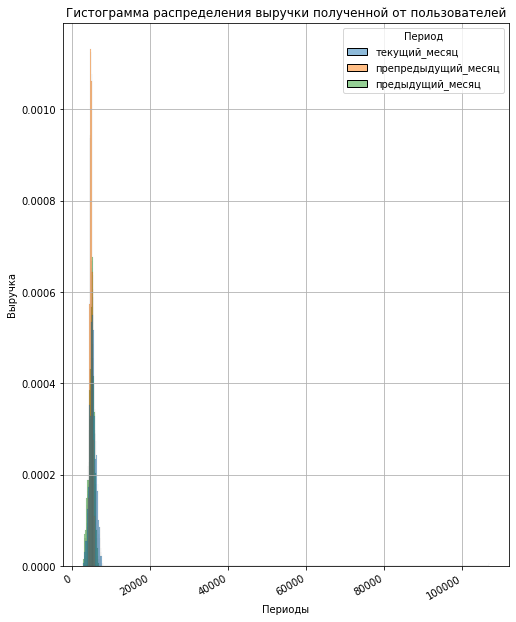

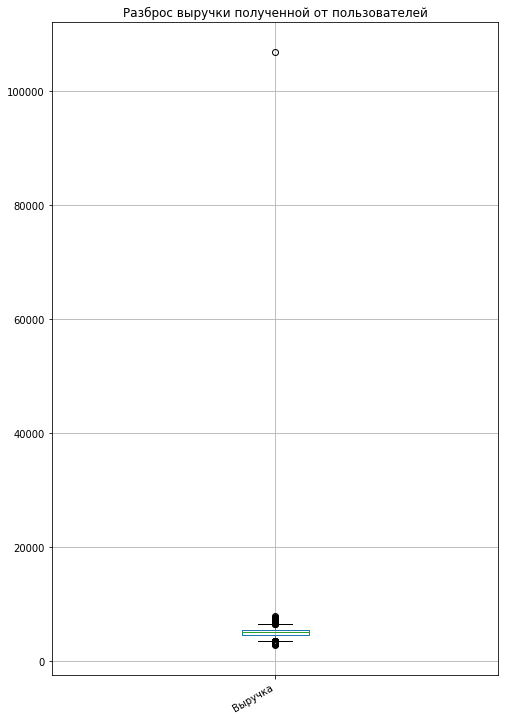

In [22]:
#проверим таблицу с выручкой магазина
plt.figure(figsize=(8,10))
sns.histplot(market_money_active, x='Выручка', hue='Период', stat='density', common_norm=False, legend=True)
plt.title('Гистограмма распределения выручки полученной от пользователей')
plt.grid(True)
plt.xlabel('Периоды')
plt.ylabel('Выручка')
plt.xticks(rotation=30, ha='right')
plt.show()
#построим график разброса 
market_money_active['Выручка'].plot(kind='box', figsize=(8, 12))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс выручки полученной от пользователей')
plt.grid('True')
plt.show()

Видим, что в колонке с выручкой есть выбивающееся значение, рассмотрим распредление значений без аномального.

In [23]:
#отбросим выбивающиеся значения
market_money_active = market_money_active.query('Выручка <= 8000')

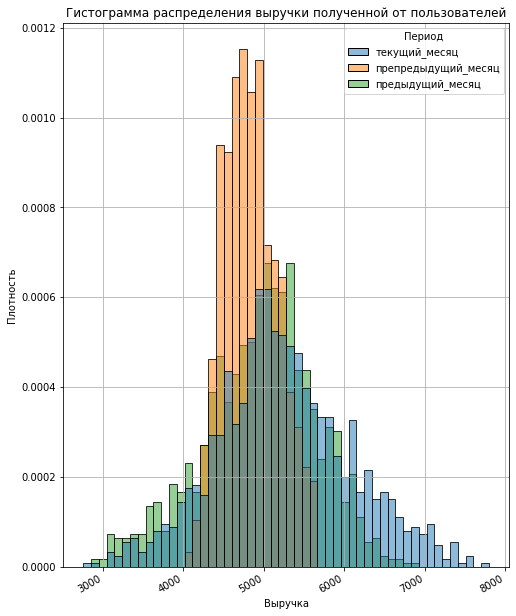

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 1 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3893 non-null   int64  
 1   Период   3893 non-null   object 
 2   Выручка  3893 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 250.7+ KB


In [24]:
#построим гистограммы с новым порогом
plt.figure(figsize=(8,10))
sns.histplot(market_money_active, x='Выручка', hue='Период', stat='density', common_norm=False, legend=True)
plt.title('Гистограмма распределения выручки полученной от пользователей')
plt.grid(True)
plt.xlabel('Выручка')
plt.ylabel('Плотность')
plt.xticks(rotation=30, ha='right')
plt.show()
#выведем распределение после отбрасывания аномальных значений
market_money_active.info()

Теперь распределение больше напоминает нормальное и видно, не смотря на то, что активность пользователей снижаеться, выручка же с каждым месяцем увеличивается.

**Рассмотрим следующую таблицу с информацией о времени, которое пользователи провели на сайте за определенный период**

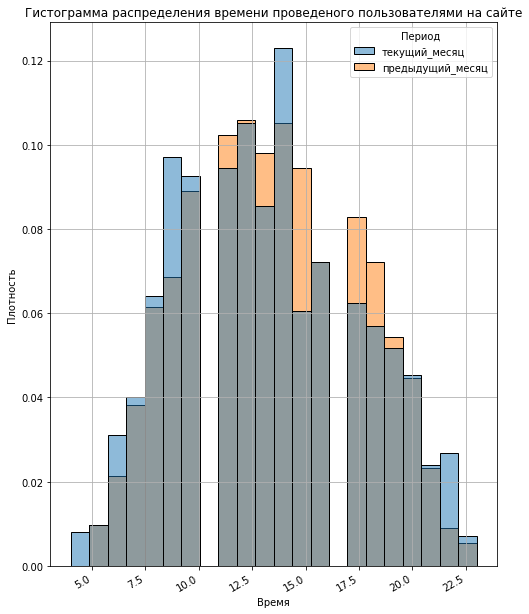

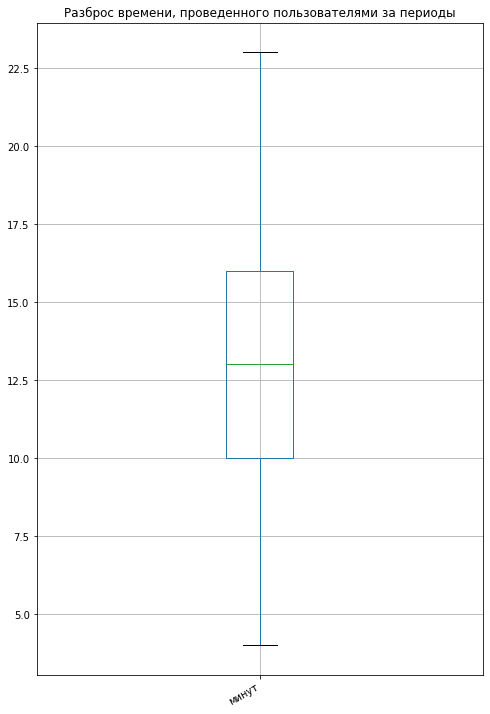

In [25]:
#построим гистограммы
plt.figure(figsize=(8,10))
sns.histplot(market_time, x='минут', hue='Период', stat='density', common_norm=False, legend=True)
plt.title('Гистограмма распределения времени проведеного пользователями на сайте')
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Плотность')
plt.xticks(rotation=30, ha='right')
plt.show()
#построим график разброса значений
market_time['минут'].plot(kind='box', figsize=(8, 12))
plt.xticks(rotation=30, ha='right')
plt.title('Разброс времени, проведенного пользователями за периоды')
plt.grid('True')
plt.show()

По графику видно, что сильной разницы между двумя периодами нет, пользователи проводили на сайте примерно одинаковое время.

**Рассмотрим таблицу с прибылью сайта**

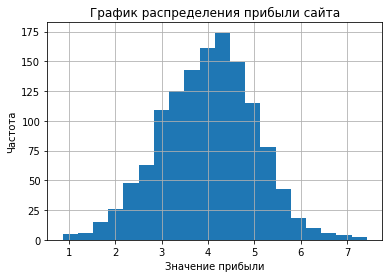

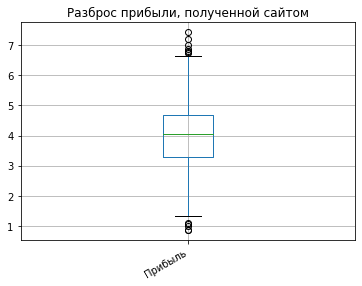

In [26]:
#построим гистограмму для таблицы с прибылью
money['Прибыль'].plot(kind='hist', bins=20, grid=True)
plt.title('График распределения прибыли сайта')
plt.xlabel('Значение прибыли')
plt.ylabel('Частота')
plt.show()
#посторим график разброса прибыли
money['Прибыль'].plot(kind='box')
plt.xticks(rotation=30, ha='right')
plt.title('Разброс прибыли, полученной сайтом')
plt.grid('True')
plt.show()

Аномальных значений в данных нет, есть небольшие выбросы.

## Объединение таблиц

In [27]:
#разделим в таблице с выручкой категории на три отдельные колонки и проверим их все
market_money_ = market_money_active.pivot(index='id', columns='Период', values='Выручка')
market_money_ = market_money_.reset_index()
market_money_.columns = ['id', 'Выручка_2й_месяц', 'Выручка_3й_месяц', 'Выручка_1й_месяц']
#в новой таблице тоже отбросим строки, которые не соответсвуют критериям, которые устанавливали в исследовательском анализе
market_money_divide = market_money_.query(
    'Выручка_2й_месяц>0 and Выручка_3й_месяц>0 and Выручка_1й_месяц>0 and Выручка_1й_месяц<8000'
)
display(market_money_divide.head())
market_money_divide.shape

,id,Выручка_2й_месяц,Выручка_3й_месяц,Выручка_1й_месяц
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5


(1296, 4)

In [28]:
#проделаем ту же операцию в таблице со временем
market_time_divide = market_time.pivot(index='id', columns='Период', values='минут')
market_time_divide = market_time_divide.reset_index()
market_time_divide.columns = ['id', 'Минут_2й_месяц', 'Минут_1й_месяц']
display(market_time_divide.head())
market_time_divide.shape

,id,Минут_2й_месяц,Минут_1й_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


(1300, 3)

In [29]:
market_data_total = market_data.merge(market_money_divide, on='id', how='left')
market_data_total = market_data_total.merge(market_time_divide, on='id', how='left')
completeness_check(market_data_total, 'со всей информацией')
market_data_total.info()
market_data_total

Пропусков в таблице со всей информацией
id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_2й_месяц                       4
Выручка_3й_месяц                       4
Выручка_1й_месяц                       4
Минут_2й_месяц                         0
Минут_1й_месяц                         0
dtype: int64
Полных дубликатов в таблице со всей информацией - 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_2й_месяц,Выручка_3й_месяц,Выручка_1й_месяц,Минут_2й_месяц,Минут_1й_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


При объединении таблиц появились 4 пропуска в колонках с выручкой по периодам, т.к. это очень малое число можно отбросить их

In [30]:
#удалим пропуски
market_data_total = market_data_total.dropna()
#проверим общее число строк и колонок
display(market_data_total.shape)
#выведем информацию по пропускам
completeness_check(market_data_total, 'со всей информацией')
display(market_data_total.head())
market_data_total.info()

(1296, 18)

Пропусков в таблице со всей информацией
id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_2й_месяц                       0
Выручка_3й_месяц                       0
Выручка_1й_месяц                       0
Минут_2й_месяц                         0
Минут_1й_месяц                         0
dtype: int64
Полных дубликатов в таблице со всей информацией - 0


,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_2й_месяц,Выручка_3й_месяц,Выручка_1й_месяц,Минут_2й_месяц,Минут_1й_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

## Корреляционный анализ

Проведем корреляционный анализ итоговой таблицы

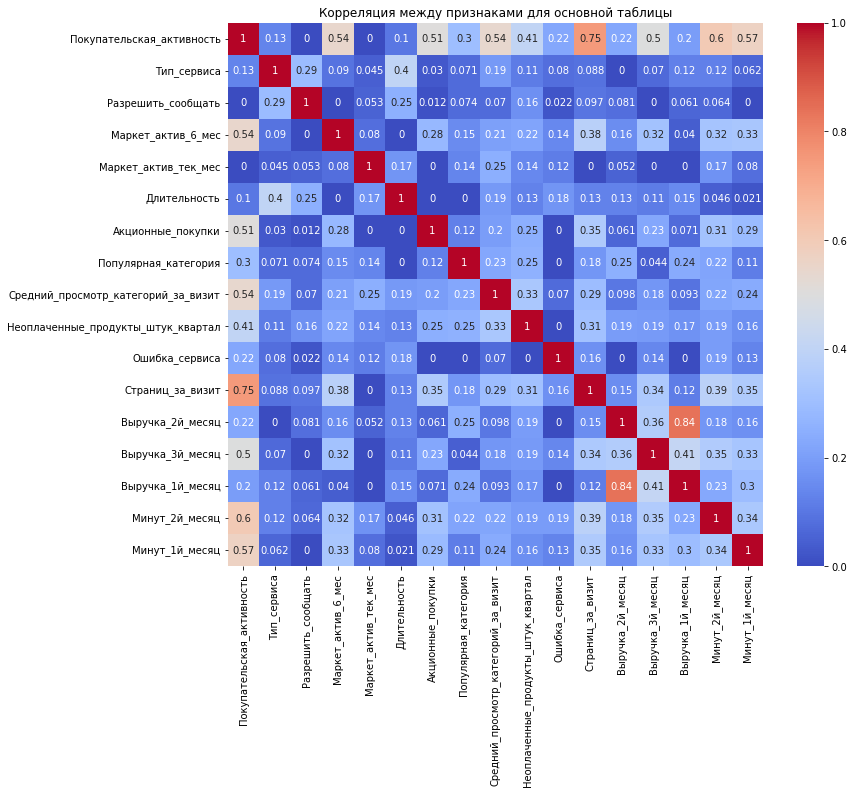

In [31]:
#используем для этого более подходящую библитеку phik,
#которая может найти коэффициент корреляции между числовыми и категориальными признаками
market_data_total_corr = market_data_total.drop('id', axis=1)
market_data_total_corr = market_data_total_corr.phik_matrix(
    interval_cols=['Маркет_актив_6_мес',
                   'Длительность',
                   'Акционные_покупки',
                   'Выручка_2й_месяц',
                   'Выручка_3й_месяц',
                   'Выручка_1й_месяц'
                  ]
)
plt.figure(figsize=(12, 10))
sns.heatmap(market_data_total_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками для основной таблицы')
plt.show()

При просмотре таблицы корреляции мультиколлинеарности не обнаружили.     
Есть признаки, которые коррелируют с целевым и имеют коэффициент больше 0.5 или равный такие как: "Маркет_актив_6_мес", "Акционные покупки", "Средний_просмотр_категорий_за_визит", "Неоплаченные_продукты_штук_квартал", "Страниц_за_визит", "Выручка_3й_месяц", "Минут_1й_месяц" и "Минут_2й_месяц".

## Работа с пайплайном

Чтобы обработать результат сразу нескольких моделей построим пайплайн, который облегчит обработку и последующее обучение моделей и найдем лучшую из них с помощью мультискоринга.

In [32]:
#сделаем столбец 'id' как индекс для таблицы
market_data_total = market_data_total.set_index('id')

In [33]:
#разделим данные на две выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_data_total.drop(['Покупательская_активность'], axis=1),
    market_data_total['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_data_total['Покупательская_активность'])

In [34]:
#подготовим колонки, которые нужно будет преобразовать
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип_сервиса', 'Разрешить_сообщать']

In [35]:
num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_2й_месяц',
    'Выручка_3й_месяц',
    'Выручка_1й_месяц',
    'Минут_2й_месяц',
    'Минут_1й_месяц'
]
#создаем пайплайн для ohe кодирования
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)
#пайплайн для ord кодирования 
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['нет','да']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
#создаем финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [36]:
#саздадим гиперпараметры для моделей и для перебора методов масштабирования для числовых признаков
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8),
        'models__max_features': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [37]:
#через автоматический перебор моделей найдем лучшую
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [38]:
randomized_search.fit(X_train, y_train)
#выведем лучшую модель и её параметры
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика roc_auc для лучшей модели:
 0.8962153897699352

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  

In [39]:
#проверим лучшую модель на тестовой выборке и выведем её ROC-auc
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9163531933826802


Сравним нашу модель с базовым классификатром DummyClassifier.

In [40]:
#определим базовую модель
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке для базового классификатора модели: {roc_auc_score(y_test, dummy_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке для базового классификатора модели: 0.5


С такой вероятностью предсказания базовая модель не отличается от подбрасывания монетки, значит выбранная лучшая модель справляется со своей задачей очень хорошо.

При проверке моделей лучший результат по выбранной метрике показала логистическая регрессия со значением в 0.89 на обучающей выборке и 0.91 на тестовой выборке.  

Метод оценивания ROC-auc хорошо подходит в нашей ситуации т.к. она независима от порога классификации модели чем выше значение метода тем лучше модель различает предсказываемые классы.

In [41]:
#подготовим данные для обучения лучшей моделью
X_train_best = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

X_test_best = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

#обучаем модель логистической регрессии для получения предсказаний
best_model_shap = LogisticRegression(C=3, penalty='l1', random_state=RANDOM_STATE, solver='liblinear')
best_model_shap.fit(X_train_best.values, y_train)

LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

## SHAP-визуализация важности признаков

100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


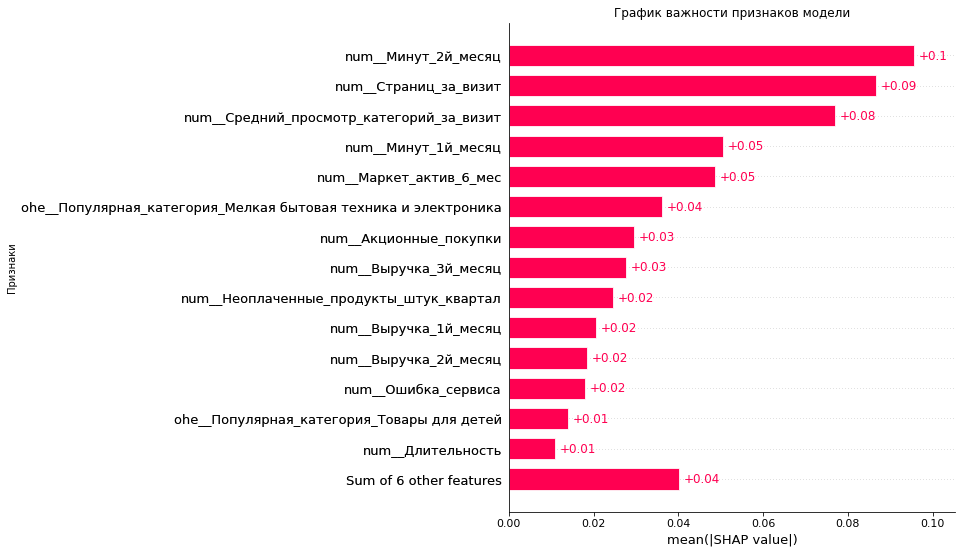

In [42]:
# Создание объекта KernelExplainer с вероятностями для одного класса
explainer = shap.KernelExplainer(lambda x: best_model_shap.predict_proba(x)[:, 1], shap.sample(X_train_best, 10))

# Рассчет SHAP значений для тестовых данных
shap_values = explainer(shap.sample(X_test_best, 10))

# Визуализация
shap.plots.bar(shap_values, max_display=15, show=False)
plt.title('График важности признаков модели')
plt.ylabel('Признаки')
plt.show()

Изучив график важности признаков лучшей модели заметили логичный вывод, время проведенное пользователем на сайте сильно влияет на его активность и чем меньше времени пользователь проводит за месяц, тем более вероятно снижение его активности на сайте - тут вопросов нет, разберем другие признаки. На активность так же влияют среднее число страниц и среднее число категорий, которые пользователь просмотрел. Так же стоит заметить, что признак связанный с акционными покупками находиться в середине перечня, что делает его важным для нашего исследования. Неоплаченные продукты тоже побуждают пользователей возвращаться на сайт и если учесть признак с акционными покупками, то можно предположить, что будь на неоплаченный товар акция или скидка, то пользватель мог бы приобрести данный товар с большим желанием. Так же видим две категории, которые могут влиять на активность пользователей, а значит их можно назвать популярнее других - это мелкая бытовая техника и электроника; товары для детей.

## Сегментация покупателей

На данном этапе воспользуемся предсказанными значениями из нашей модели и добавим к ним прибыль, которую пользователи приносят сайту, чтобы найти покупателей, чья активность снижается и они до этого приносили большую прибыль сайту. Так же стоит проверить на какие категории товаром данные покупатели тратили своё время и деньги, чтобы разработать сратегию по их удержанию на сайте. 

,id,Прибыль,Вероятность_снижения
0,216161,4.69,0.013116
1,215654,2.75,0.989160
2,216307,3.16,0.100315
3,215501,3.74,0.821361
4,215934,4.40,0.505902
...,...,...,...
319,215429,3.71,0.968205
320,216233,4.62,0.046957
321,215716,4.07,0.889868
322,216141,1.97,0.180913


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


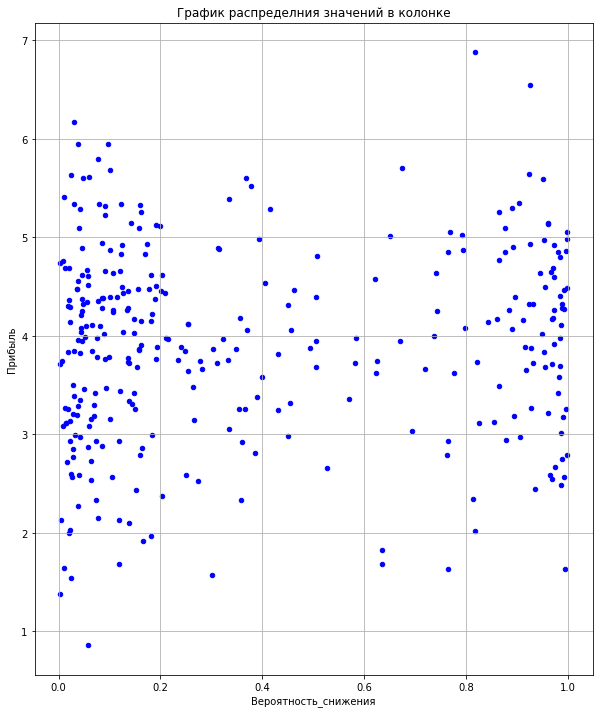

In [43]:
#выделим значения вероятностей для класса "снизилась" и создадим отдельный датафрейм с индексами соответствующими предсказаниям
best_model = LogisticRegression(C=3, penalty='l1', random_state=RANDOM_STATE, solver='liblinear')
best_model.fit(X_train_best, y_train)
predicts = pd.DataFrame({'id': X_test.index, 'Вероятность_снижения': best_model.predict_proba(X_test_best)[:, 1]})
#объединим таблицу вероятностей и таблицу с прыбылью
money_with_predicts = money.merge(predicts, on='id', how='right')
display(money_with_predicts)
#построим график разбросса пользователей и их прибылью, чтобы наглядно увидеть сколько из них имеют большую вероятность
#к снижению активности на сайте
money_with_predicts.plot(
    x='Вероятность_снижения',
    y='Прибыль',
    kind='scatter',
    figsize=(10, 12),
    grid=True,
    legend=True,
    c='b'
)
plt.title('График распределния значений в колонке')
plt.show()

Видим по графику разброса, что есть немалое число пользователей, которые имея высокую прибыль для сайта так же имеют и высокий шанс снижения активности или в принципе отказ от услуг сайта. Рассмотрим отдельно эту категорию выделив их: значением прибыли от 3 и с вероятностью снижения активности более 0.5 сопоставив их с категориями товарных групп.

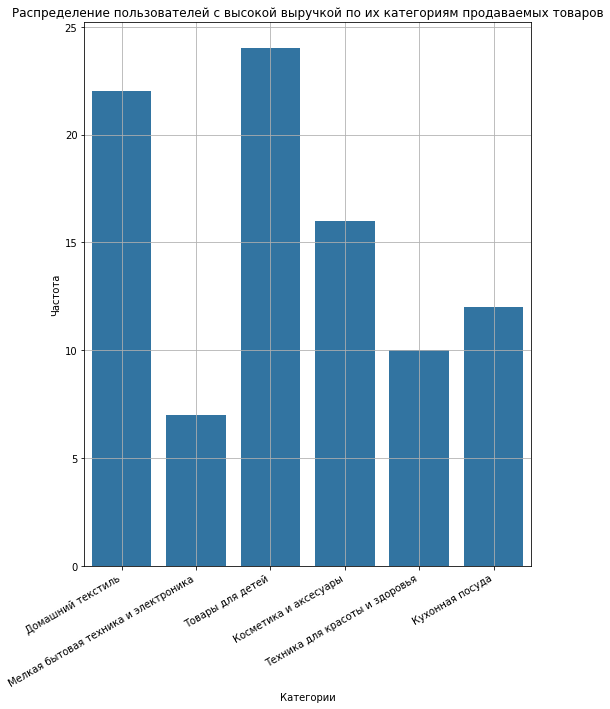

In [44]:
plt.figure(figsize=(8,10))
X_test_with_preds = X_test.merge(money_with_predicts, on='id', how='right')
sns.countplot(X_test_with_preds.query('Прибыль > 2.99 and Вероятность_снижения > 0.5'), x='Популярная_категория')
plt.title('Распределение пользователей с высокой выручкой по их категориям продаваемых товаров')
plt.grid(True)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Категории')
plt.ylabel('Частота')
plt.show()

Видно что рассматриваемые пользователи наиболее часто покупали такие товарные категории в порядке убывания: на первом месте идут товары для детей; на втором - домашний текстиль; на третьем - косметика и акссесуары; далее все остальные - кухонная посуда; техника для красоты и здоровья; мелкая бытовая техника и электроника.  
Значит чтобы восстановить прежню активность для этих пользователей следует привлечь их внимание через три популярные категории предлагая им всевозможные акции, скидки и тому подобные вещи, чтобы заинтересовать их и удержать на сайте.

## Общий вывод

Как говорилось в начале проекта - интернет магазин "В один клик" занимается продажей разных товаров. В результате отчета о посещении магазина, выяснилось, что число пользователей начало снижаться и это негативно влияет на продажи компании. Было принято решение разработать модель машинного обучения, которая сможет сделать персонализированные предложения для постоянных клиентов магазина и сможет удержать их на сайте.  

В качестве исходных были предоставленны следующие данные: данные о активности пользователей на самом сайте; данные о выручке, которую пользователи приносят сайту; данные о времени проведенном пользователями на сайте и данные о прибыли полученной от пользователей.  

При проведении предобработки в таблице активности пользователей была исправлена ошибка в названии категории, так же и в таблице со временем. Пропусков и дубликатов в таблицах не обнаружили. Был исправлен явный выброс в таблице с выручкой, который мог бы повлиять на предсказания будущей модели.  

Для выявления лучшей модели для предсказаний воспользовались методом под названием "пайплайн", который может вмешать в себя сразу несколько выидов масштабирования и кодирования признаков, так же с помощью него есть возможность проверить сразу несколько моделей с различными параметрами для них. После необходимых для пайплайна операций он был использован совместно с методом для поиска лучшего сочетания внутренних параметров пайплайна, а именно с помощью метода "RandomizedSearch". Для проверки качества модели была выбрана метрика ROC-auc, которая строит график точности предсказаний и учитывает в себе ошибки первого и второго рода. По результатам метода  RandomizedSearch лучший результат на обучающей выборке получила модель логистической регрессии с числом ROC-auc 0.896, а на тестовой выборке 0.91. Так же было проведено сравнение с моделью "DummyClassifier", которая с той метрикой показала результат в 0.5. 

Вот параметры лучшей модели:  
**LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')**.  

Для отдельного рассмотрения выбрали пользователей, у которых согласно прогнозу модели начнет снижаться активность и при этом они имеют относительно высокую прибыль для площадки. При исследовании данного сегмента пользователей так же рассмотрели популярные для них категории товаров и выявили, что наибольшей популярностью обладает категория - "товары для детей".  
Как уже было сказано ранее, чтобы удержать пользователей на сайте стоит ввести различные акционные предложения на популярные товары и всевозможные скидки на них, к этому дополнительно, можно добавить оповещения для акционных товаров, если они находяться у пользователей в списке неоплаченных, что побудит их зайти и продумать выгоду для себя от покупки желаемого товара со сниженной ценой. В идеале настроить гибкие рекомендации, которые отталкивались бы от просмотренных человеком категорий товаров и искало бы смежные с ними: либо обычные, либо со скидкой, создавая тем самым комплекты к ним.